# 1. Imports

In [ ]:
import sys
print(sys.executable)


/home/rodrigo-pinto22/anaconda3/envs/FAA/bin/python


In [ ]:
#%pip install scikit-learn
#%pip install tensorflow
import pickle
import csv
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import PIL as pil
import matplotlib.pyplot as plt
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
from PIL import Image
import requests
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


## Data Analysis

In [7]:
train_datacsv = pd.read_csv('~/dataset/GTSRB/Train.csv')
test_datacsv = pd.read_csv('~/dataset/GTSRB/Test.csv')
print(type(train_datacsv))

<class 'pandas.core.frame.DataFrame'>


In [8]:
train_datacsv.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

In [9]:
test_datacsv.columns

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

### Processamento imagens de treino

In [12]:
# Caminho da pasta principal do dataset
base_path = "/home/rodrigo-pinto22/dataset/GTSRB"

# Listas para armazenar imagens e labels
images = []
labels = []


    
# Percorre as linhas do CSV
for _, row in train_datacsv.iterrows():
    img_path = os.path.join(base_path, row['Path'])
    #img_path = img_path.replace('/', os.sep) 
    
    # Lê a imagem
    img = pil.Image.open(img_path)
    img = np.array(img)
    if img is None:
        continue
    
    # Recorta o ROI (sinal de trânsito)
    roi = img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
    
    # Redimensiona para 32x32
    roi_resized = cv2.resize(roi, (32, 32))
    
    # Normaliza (0–1)
    roi_resized = roi_resized / 255.0
    
    # Guarda a imagem e o rótulo
    images.append(roi_resized)
    labels.append(row['ClassId'])

# Converte para arrays NumPy
X = np.array(images, dtype=np.float32)
y = np.array(labels)

print("Shape das imagens:", X.shape)
print("Shape dos labels:", y.shape)
print("Número de classes:", len(np.unique(y)))

Shape das imagens: (39209, 32, 32, 3)
Shape dos labels: (39209,)
Número de classes: 43


In [14]:
# Caminho da pasta principal do dataset
base_path = "/home/rodrigo-pinto22/dataset/GTSRB"

# Listas para armazenar imagens e labels
images = []
labels = []


    
# Percorre as linhas do CSV
for _, row in test_datacsv.iterrows():
    img_path = os.path.join(base_path, row['Path'])
    img_path = img_path.replace('/', os.sep) 
    
    # Lê a imagem
    img = pil.Image.open(img_path)
    img = np.array(img)
    if img is None:
        continue
    
    # Recorta o ROI (sinal de trânsito)
    roi = img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
    
    # Redimensiona para 32x32
    roi_resized = cv2.resize(roi, (32, 32))
    
    # Normaliza (0–1)
    roi_resized = roi_resized / 255.0
    
    # Guarda a imagem e o rótulo
    images.append(roi_resized)
    labels.append(row['ClassId'])

# Converte para arrays NumPy
X_test = np.array(images, dtype=np.float32)
y_test = np.array(labels)

print("Shape das imagens:", X_test.shape)
print("Shape dos labels:", y_test.shape)
print("Número de classes:", len(np.unique(y_test)))

Shape das imagens: (12630, 32, 32, 3)
Shape dos labels: (12630,)
Número de classes: 43


### Shuffle

In [15]:
shuffle_index = np.random.permutation(len(X))
X = X[shuffle_index]
y = y[shuffle_index]

### Train, Cross Val and Test Partitions

In [16]:
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_val = X[int(len(X)*0.8):int(len(X))]
y_val = y[int(len(y)*0.8):int(len(y))]


# Save npArrays

In [17]:
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'X_train.npy'), X_train)
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'y_train.npy'), y_train)
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'X_test.npy'), X_test)
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'y_test.npy'), y_test)
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'X_val.npy'), X_val)
np.save(os.path.join("/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1", 'y_val.npy'), y_val)


# Import npArrays

In [86]:
X_train = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/X_train.npy")
y_train = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/y_train.npy")
X_test = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/X_test.npy")
y_test = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/y_test.npy")
X_val = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/X_val.npy")
y_val = np.load(r"/home/rodrigo-pinto22/Documents/MCD/Ano_1/Semestre_1/FAA/Project_1/y_val.npy")

### Shape

In [108]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31367, 32, 32, 3)
X_val shape: (7842, 32, 32, 3)
X_test shape: (12630, 32, 32, 3)
y_train shape: (31367,)
y_val shape: (7842,)
y_test shape: (12630,)


In [109]:
set_y_train = set(y_train)
set_y_val = set(y_val)
set_y_test = set(y_test)

In [110]:
print(set_y_train)
print(set_y_val)
print(set_y_test)

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42)}
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(2

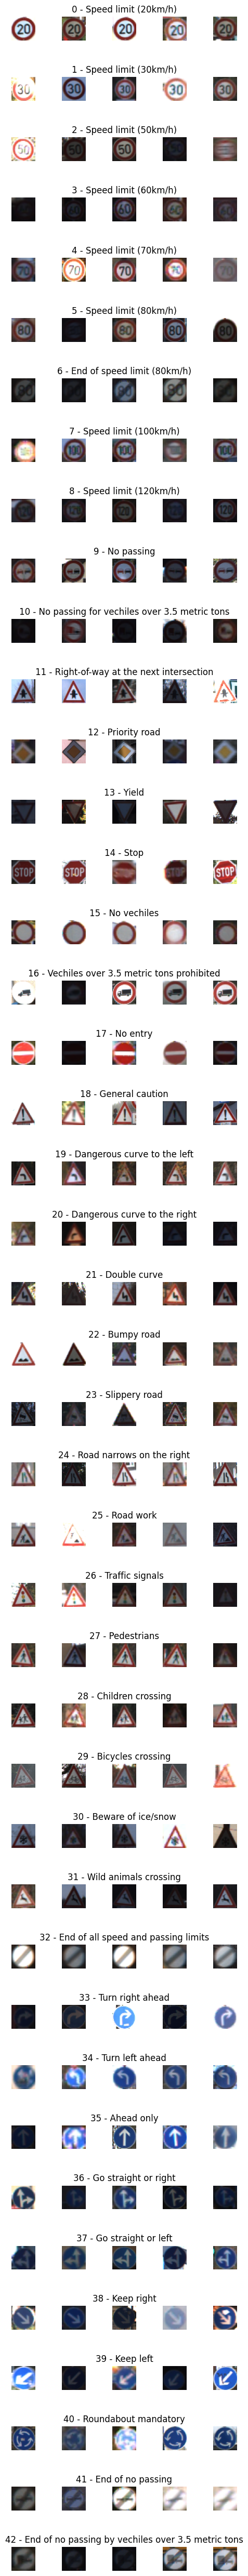

In [146]:
data = pd.read_csv(r"~/dataset/GTSRB/signames.csv")

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

In [24]:
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


[164, 1805, 1811, 1133, 1589, 1462, 326, 1155, 1139, 1161, 1611, 1062, 1699, 1767, 635, 508, 338, 911, 946, 164, 282, 276, 300, 411, 218, 1196, 481, 181, 398, 211, 362, 609, 187, 543, 327, 981, 312, 165, 1636, 243, 281, 193, 188]


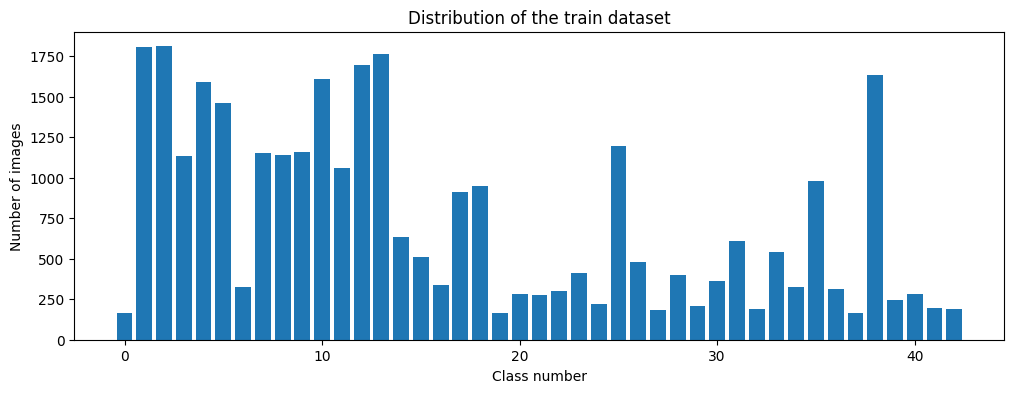

In [25]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
15


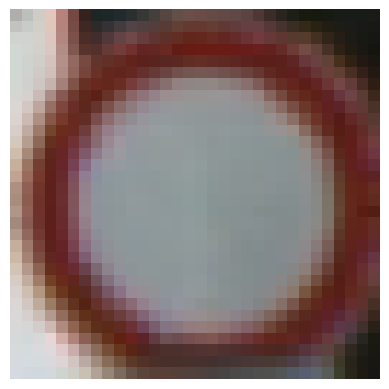

In [26]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [27]:
X_train.dtype

dtype('float32')

### Nota:

Antes de enviar a imagem para a função cv2.cvtColor, foi necessário modificar o tipo de dados de float32 para uint8, porque a função equalizeHist() não aceita dados do tipo float32

A função equalizeHist() redistribui os níveis de cinzento de modo a usar melhor toda a faixa de 0–255.
Em termos simples:

Se a imagem estava escura (muitos pixels próximos de 0), ela clareia;

Se estava muito clara, aumenta o contraste nas zonas mais “planas”;

No fim, o histograma fica mais uniforme (distribuído).

Visualmente, isto melhora contraste e definição, especialmente em imagens com iluminação desigual.

In [17]:
img = X_train[1000]
img = (img * 255).astype(np.uint8)

In [18]:
img.dtype

dtype('uint8')

(32, 32)


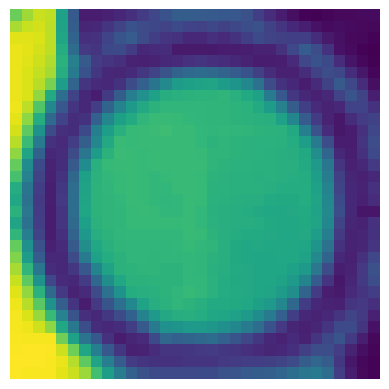

In [30]:

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


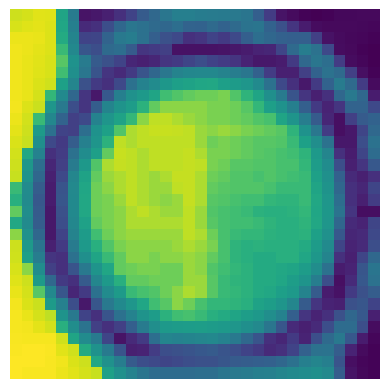

In [31]:
img = cv2.equalizeHist((img * 255).astype(np.uint8))/255
plt.imshow(img)
plt.axis("off")
print(img.shape)

## Reshaping

### Reshape Funcions

In [50]:
def grayscale(img):
    if img.ndim<4:
        img1 = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        return img1
    else:
        img1 = np.array([
            cv2.cvtColor((i * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
            for i in img
        ])
        return img1

def equalize(img):
    if img.ndim<3:
        img2 = cv2.equalizeHist(img)
        return img2.astype('float32') / 255.0
    else:
        img2 = np.array([
            cv2.equalizeHist((i * 255).astype('uint8')) / 255.0
            for i in img
        ])
        return img2

def preproc(img):
    
    img1 = grayscale(img)
    img2 = equalize(img1)
    if img.ndim<3:
        img2 = img2.reshape(1, 32, 32, 1)
        print("final:", img2.shape)  
        return img2
    else:
        img2 = img2.reshape(len(img2), 32, 32, 1)
        return img2

def preprocOutput(y):
    y = to_categorical(y, num_classes=43)
    return y

In [4]:
X_train_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_train
])


print(X_train_gray.shape)
print(X_train_gray.dtype)

X_train_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_train_gray
])

(31367, 32, 32)
float64


In [5]:
X_val_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_val
])


print(X_val_gray.shape)
print(X_val_gray.dtype)

X_val_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_val_gray
])

(7842, 32, 32)
float64


In [6]:
X_test_gray = np.array([
    cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY) / 255.0
    for img in X_test
])


print(X_test_gray.shape)
print(X_test_gray.dtype)

X_test_grayeq = np.array([
    cv2.equalizeHist((img * 255).astype('uint8')) / 255.0
    for img in X_test_gray
])

(12630, 32, 32)
float64


In [7]:
X_trainv2 = X_train_grayeq.reshape(len(X_train_grayeq), 32, 32, 1)
X_valv2 = X_val_grayeq.reshape(len(X_val_grayeq), 32, 32, 1)
X_testv2 = X_test_grayeq.reshape(len(X_test_grayeq), 32, 32, 1)

### ANÁLISE DETALHADA DO DESBALANCEAMENTO 

In [65]:
print("=== ANÁLISE DETALHADA DO DESBALANCEAMENTO ===")

# Calcular estatísticas de desbalanceamento
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Taxa de desbalanceamento (max/min): {imbalance_ratio:.2f}:1")
print(f"Classe mais frequente: {class_counts.argmax()} com {class_counts.max()} imagens")
print(f"Classe menos frequente: {class_counts.argmin()} com {class_counts.min()} imagens")

# Classes críticas (poucas amostras)
few_samples_threshold = 100
critical_classes = np.where(class_counts < few_samples_threshold)[0]
if len(critical_classes)<1:
    print(f"Classes com menos de {few_samples_threshold} imagens: None")
print(f"IDs das classes críticas: {list(critical_classes)}")

=== ANÁLISE DETALHADA DO DESBALANCEAMENTO ===
Taxa de desbalanceamento (max/min): 11.04:1
Classe mais frequente: 2 com 1811 imagens
Classe menos frequente: 0 com 164 imagens
Classes com menos de 100 imagens: None
IDs das classes críticas: []


* Podemos concluir que a classe mais frequente é a 1 com cerca de 1785 imagens e a menos frequente é a 37 com 161 .
* Porque está analise é importante ? É importante analisar o desbalanceanento , isto por que não o tratamos o sistema apenas irá funcionar bem para os sinais mais comuns e vai falar para os mais raros -  mas que podem ser os mais importantes a nivel de segurança.

### Estratégias para o Desbalanceamento

Pesos calculados para cada classe:
Classe 0: peso 4.45
Classe 1: peso 0.40
Classe 2: peso 0.40
Classe 3: peso 0.64
Classe 4: peso 0.46
Classe 5: peso 0.50
Classe 6: peso 2.24
Classe 7: peso 0.63
Classe 8: peso 0.64
Classe 9: peso 0.63
Classe 10: peso 0.45
Classe 11: peso 0.69
Classe 12: peso 0.43
Classe 13: peso 0.41
Classe 14: peso 1.15
Classe 15: peso 1.44
Classe 16: peso 2.16
Classe 17: peso 0.80
Classe 18: peso 0.77
Classe 19: peso 4.45
Classe 20: peso 2.59
Classe 21: peso 2.64
Classe 22: peso 2.43
Classe 23: peso 1.77
Classe 24: peso 3.35
Classe 25: peso 0.61
Classe 26: peso 1.52
Classe 27: peso 4.03
Classe 28: peso 1.83
Classe 29: peso 3.46
Classe 30: peso 2.02
Classe 31: peso 1.20
Classe 32: peso 3.90
Classe 33: peso 1.34
Classe 34: peso 2.23
Classe 35: peso 0.74
Classe 36: peso 2.34
Classe 37: peso 4.42
Classe 38: peso 0.45
Classe 39: peso 3.00
Classe 40: peso 2.60
Classe 41: peso 3.78
Classe 42: peso 3.88

ANÁLISE DOS PESOS MÁXIMOS E MÍNIMOS

 PESO MÍNIMO vs maximo
Classe(mini

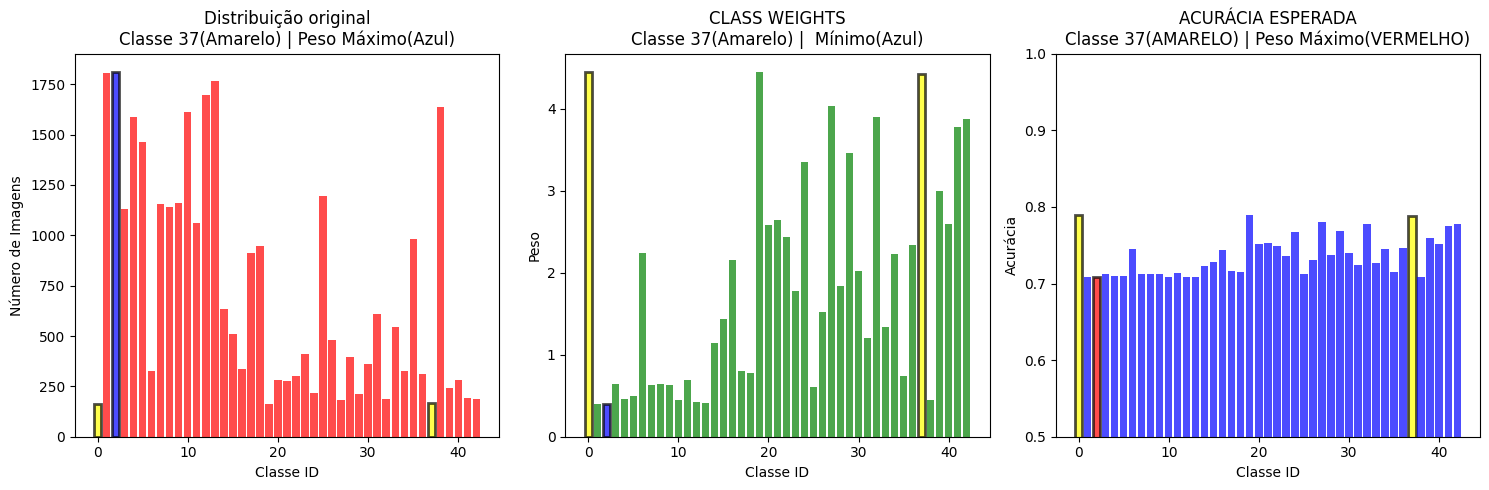

In [66]:
# ===  Calcular Pesos e Visualizar comparações ===



class_counts = np.bincount(y_train)  # Recalcular se necessário

# Calcular os pesos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para cada classe:")
for class_id, weight in class_weights_dict.items():
    print(f"Classe {class_id}: peso {weight:.2f}")

#Analise :  CALCULAR PESO MÁXIMO E MÍNIMO 
print("\n" + "="*60)
print("ANÁLISE DOS PESOS MÁXIMOS E MÍNIMOS")
print("="*60)


classe_peso_max = max(class_weights_dict, key=class_weights_dict.get)
peso_max = class_weights_dict[classe_peso_max]

classe_peso_min = min(class_weights_dict, key=class_weights_dict.get)
peso_min = class_weights_dict[classe_peso_min]



print(f"\n PESO MÍNIMO vs maximo")
print(f"Classe(minimo) {classe_peso_min}: peso {peso_min:.2f} | classe(maximo) {classe_peso_max}: peso {peso_max:.2f} ")
print(f"Número de imagens(minimo): {class_counts[classe_peso_min]} | Número de imagens(maximo): {class_counts[classe_peso_max]}")
print(f"Representação(minimo): {class_counts[classe_peso_min]/len(y_train)*100:.1f}% do dataset | Representação(maximo): {class_counts[classe_peso_max]/len(y_train)*100:.1f}% do dataset")


plt.figure(figsize=(15, 5))

# Gráfico 1: Distribuição original
plt.subplot(1, 3, 1)
bars = plt.bar(range(43), class_counts, color='red', alpha=0.7)
# Destacar a classe 37 e a classe 2 ( minimo e maximo)
bars[37].set_color('yellow')
bars[37].set_edgecolor('black')
bars[37].set_linewidth(2)
bars[classe_peso_max].set_color('yellow')
bars[classe_peso_max].set_edgecolor('black')
bars[classe_peso_max].set_linewidth(2)
bars[classe_peso_min].set_color('blue')
bars[classe_peso_min].set_edgecolor('black')
bars[classe_peso_min].set_linewidth(2)
plt.title('Distribuição original\nClasse 37(Amarelo) | Peso Máximo(Azul)')
plt.xlabel('Classe ID')
plt.ylabel('Número de Imagens')

# Gráfico 2: Class Weights
plt.subplot(1, 3, 2)
weights = [class_weights_dict[i] for i in range(43)]
bars = plt.bar(range(43), weights, color='green', alpha=0.7)
bars[37].set_color('yellow')
bars[37].set_edgecolor('black')
bars[37].set_linewidth(2)
bars[classe_peso_max].set_color('yellow')
bars[classe_peso_max].set_edgecolor('black')
bars[classe_peso_max].set_linewidth(2)
bars[classe_peso_min].set_color('blue')
bars[classe_peso_min].set_edgecolor('black')
bars[classe_peso_min].set_linewidth(2)
plt.title('CLASS WEIGHTS\nClasse 37(Amarelo) |  Mínimo(Azul)')
plt.xlabel('Classe ID')
plt.ylabel('Peso')

# Gráfico 3: Efeito esperado apos o balanceamento
plt.subplot(1, 3, 3)
expected_accuracy = [min(0.95, 0.7 + weight*0.02) for weight in weights]
bars = plt.bar(range(43), expected_accuracy, color='blue', alpha=0.7)
bars[37].set_color('yellow')
bars[37].set_edgecolor('black')
bars[37].set_linewidth(2)
bars[classe_peso_max].set_color('yellow')
bars[classe_peso_max].set_edgecolor('black')
bars[classe_peso_max].set_linewidth(2)
bars[classe_peso_min].set_color('red')
bars[classe_peso_min].set_edgecolor('black')
bars[classe_peso_min].set_linewidth(2)
plt.title('ACURÁCIA ESPERADA\nClasse 37(AMARELO) | Peso Máximo(VERMELHO)')
plt.xlabel('Classe ID')
plt.ylabel('Acurácia')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

* No primeiro gráfico podemos observar o desbalanceamento original, onde algumas classes têm 1785 imagens e outras apenas 161, com uma taxa de 11.09, o que significa que existem classes com 11x mais exemplos que a menor. Como resultado o modelo tenderá a aprender melhor classes maiores.

* Já o gráfico 2 mostra uma possível solução. Os Class Weights dá pesos maiores para classes com menos exemplos, ou seja, durante o treino os erros em classes menores "pesam mais" na loss function.

* Adicionamos também já os pesos correspondentes a cada classe, foi relevante calcular o valor do peso mínimo e máximo para assim comprovar que foram atribuídos à classe com maior número de imagens e à com menor respetivamente.

* O valor dos pesos foi calculado pelo `compute_class_weight()` onde o sklearn faz o seu cálculo, no entanto a fórmula utilizada é a seguinte:

<div align="center">

`peso = total_imagens / (n_classes × imagens_da_classe)`

</div>

## Criação de um modelo e aplicar os pesos calculados anteriormente

In [85]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(100, (5, 5), activation='relu', input_shape=(32, 32, 1)),
    ## criamos 32 filtros 3x3 para detetar caracteristicas basicas tipo bordas e cores
    tf.keras.layers.Conv2D(100, (5, 5), activation='relu'),
    # criamos agora 64 filtros 3x3 para detetar caracteristicas mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos a imagem para metade mantendo as caracteristicas mais importantes
    tf.keras.layers.Conv2D(100, (5, 5), activation='relu'),
    # criamos agora 64 filtros 3x3 para detetar caracteristicas mais complexas
    tf.keras.layers.Conv2D(100, (5, 5), activation='relu'),
    # criamos 128 filtros 3x3 para detetar caracteristicas ainda mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos novamente a imagem
    tf.keras.layers.Dropout(0.5),
    # dropout para evitar overfitting
    tf.keras.layers.Flatten(),
    # achatamos a matriz 3D em um vetor 1D
    tf.keras.layers.Dense(300, activation='relu'),
    # camada densa com 512 neurônios para aprender combinações complexas de características
    tf.keras.layers.Dense(43, activation='softmax')
    # camada de saída com 43 neurônios (uma para cada classe) e ativação softmax
])

# Compilar o modelo
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model2.summary())

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)              │ (None, 28, 28, 100)    │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 24, 24, 100)    │       250,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 12, 12, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 8, 8, 100)      │       250,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 4, 4, 100)      │       250,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 2, 2, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 2, 2, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 300)            │       120,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 43)             │        12,943 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 886,143 (3.38 MB)

 Trainable params: 886,143 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

None


In [87]:

X_train = preproc(X_train)
X_val = preproc(X_val)
X_test = preproc(X_test)


y_train = preprocOutput(y_train)
y_val   = preprocOutput(y_val)


history = model2.fit(
    X_train, y_train, # Usamos os dados de treino
    class_weight=class_weights_dict,  # calculados anteriormente
    epochs=10, # Vê cada um dos dados 10 vezes
    batch_size=32,
    validation_data=(X_val, y_val)  # Para visualizar performance durante o treino
)

y_pred_prob = model2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("predicted class:", y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 195s 197ms/step - accuracy: 0.6212 - loss: 1.3911 - val_accuracy: 0.9545 - val_loss: 0.1758
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 201s 205ms/step - accuracy: 0.9309 - loss: 0.2354 - val_accuracy: 0.9810 - val_loss: 0.0719
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 234s 238ms/step - accuracy: 0.9524 - loss: 0.1454 - val_accuracy: 0.9885 - val_loss: 0.0455
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 258s 263ms/step - accuracy: 0.9664 - loss: 0.1026 - val_accuracy: 0.9902 - val_loss: 0.0400
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 203s 207ms/step - accuracy: 0.9677 - loss: 0.1091 - val_accuracy: 0.9888 - val_loss: 0.0417
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 192s 196ms/step - accuracy: 0.9767 - loss: 0.0767 - val_accuracy: 0.9908 - val_loss: 0.0397
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 229s 233ms/step - accuracy: 0.9786 - loss: 0.0670 - val_accuracy: 0.9864 - val_loss: 0.0498
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 243s 247ms/step - accuracy: 0.9770 -

In [88]:
model2.save("Base.keras")

In [91]:
# === Treinar Modelo ===

# PRIMEIRO criar o modelo 
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    ## criamos 32 filtros 3x3 para detetar caracteristicas basicas tipo bordas e cores
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos a imagem para metade mantendo as caracteristicas mais importantes
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # criamos agora 64 filtros 3x3 para detetar caracteristicas mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos novamente a imagem
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # criamos 128 filtros 3x3 para detetar caracteristicas ainda mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos novamente a imagem
    tf.keras.layers.Flatten(),
    # achatamos a matriz 3D em um vetor 1D
    tf.keras.layers.Dense(512, activation='relu'),
    # camada densa com 512 neurônios para aprender combinações complexas de características
    tf.keras.layers.Dropout(0.5),
    # dropout para evitar overfitting
    tf.keras.layers.Dense(43, activation='softmax')
    # camada de saída com 43 neurônios (uma para cada classe) e ativação softmax
])

# Compilar o modelo
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

# AGORA treinar c os pesos
print("Iniciando treino com Class Weights...")
history = model1.fit(
    X_train, y_train, # Usamos os dados de treino
    class_weight=class_weights_dict,  # calculados anteriormente
    epochs=10, # Vê cada um dos dados 10 vezes
    batch_size=32,
    validation_data=(X_val, y_val)  # Para visualizar performance durante o treino
)

y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("predicted class:", y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

/home/rodrigo-pinto22/anaconda3/envs/FAA/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_79 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,387 (1.44 MB)

 Trainable params: 377,387 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Iniciando treino com Class Weights...
Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7053 - loss: 1.0658 - val_accuracy: 0.9575 - val_loss: 0.1523
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9569 - loss: 0.1376 - val_accuracy: 0.9733 - val_loss: 0.0815
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9734 - loss: 0.0781 - val_accuracy: 0.9793 - val_loss: 0.0658
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9804 - loss: 0.0530 - val_accuracy: 0.9918 - val_loss: 0.0348
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9852 - loss: 0.0425 - val_accuracy: 0.9912 - val_loss: 0.0357
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9878 - loss: 0.0346 - val_accuracy: 0.9870 - val_loss: 0.0442
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9878 - loss: 0.0373 - val_accuracy: 0.9912 - val_loss: 0.0306
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 24s 25m

In [ ]:
# === Treinar Modelo ===

# PRIMEIRO criar o modelo 
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    ## criamos 32 filtros 3x3 para detetar caracteristicas basicas tipo bordas e cores
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos a imagem para metade mantendo as caracteristicas mais importantes
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # criamos agora 64 filtros 3x3 para detetar caracteristicas mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos novamente a imagem
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # criamos 128 filtros 3x3 para detetar caracteristicas ainda mais complexas
    tf.keras.layers.MaxPooling2D(2, 2),
    # reduzimos novamente a imagem
    tf.keras.layers.Flatten(),
    # achatamos a matriz 3D em um vetor 1D
    tf.keras.layers.Dense(512, activation='relu'),
    # camada densa com 512 neurônios para aprender combinações complexas de características
    tf.keras.layers.Dropout(0.5),
    # dropout para evitar overfitting
    tf.keras.layers.Dense(43, activation='softmax')
    # camada de saída com 43 neurônios (uma para cada classe) e ativação softmax
])

# Compilar o modelo
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model1.summary())

# AGORA treinar c os pesos
print("Iniciando treino com Class Weights...")
history = model1.fit(
    X_train, y_train, # Usamos os dados de treino
    class_weight=class_weights_dict,  # calculados anteriormente
    epochs=10, # Vê cada um dos dados 10 vezes
    batch_size=32,
    validation_data=(X_val, y_val)  # Para visualizar performance durante o treino
)

y_pred_prob = model2.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("predicted class:", y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

2025-11-15 21:57:25.419115: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 21:57:25.459830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 21:57:26.489251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/rodrigo-pinto22/anaconda3/envs/FAA/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:17632

Iniciando treino com Class Weights...
Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6025 - loss: 1.3568 - val_accuracy: 0.8950 - val_loss: 0.3960
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9477 - loss: 0.1619 - val_accuracy: 0.9421 - val_loss: 0.2442
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9693 - loss: 0.0919 - val_accuracy: 0.9496 - val_loss: 0.2133
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9816 - loss: 0.0569 - val_accuracy: 0.9568 - val_loss: 0.2109
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9854 - loss: 0.0426 - val_accuracy: 0.9612 - val_loss: 0.1566
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9889 - loss: 0.0325 - val_accuracy: 0.9657 - val_loss: 0.1432
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9857 - loss: 0.0418 - val_accuracy: 0.9652 - val_loss: 0.2080
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/ste

## Verificação da correta criação do modelo

1. Mostragem das 5 primeiras imagens do dataset:


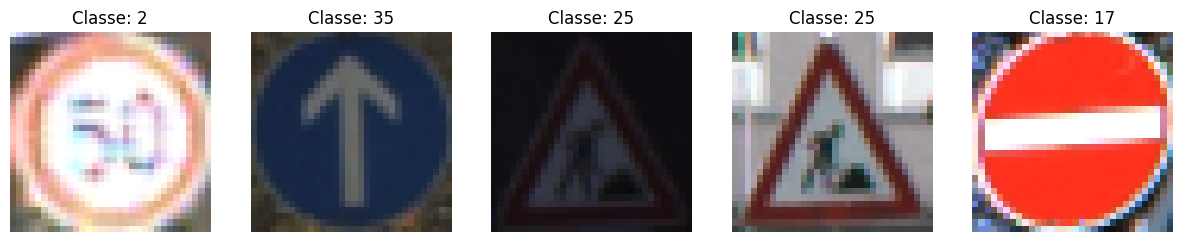

2. Teste de processamento:
Imagens de teste: (3, 32, 32, 3)
Labels reais: [ 2 35 25]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Previsões do modelo: [ 2 35 25]


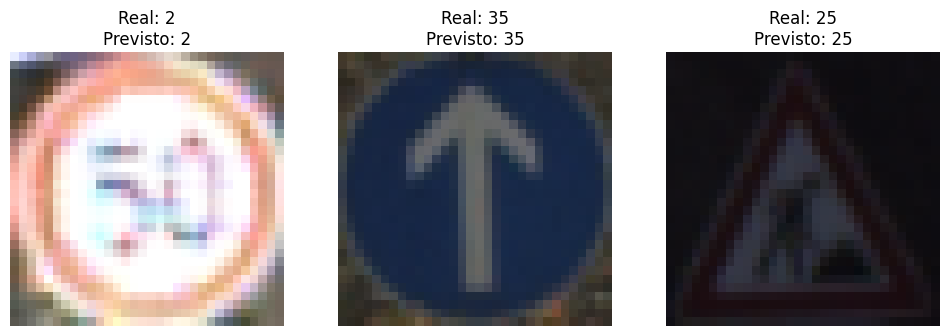

3. COMPATIBILIDADE:
Tuas imagens - Shape: (31367, 32, 32, 3)
Tuas labels - Shape: (31367,)
Modelo espera: (None, 32, 32, 3)
Modelo devolve: (None, 43)
4. TESTE DE TREINO RÁPIDO (30 segundos):
Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0067
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0982 
 Analise do treino
Acurácia final: 0.980
5. TESTE DE PREVISÃO APÓS MINI-TREINO:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Imagem real - Classe: 7
Modelo previu - Classe: 7
Probabilidades: [1.3782496e-15 3.4567180e-09 3.8371401e-10 1.4416348e-12 3.2808067e-08]...


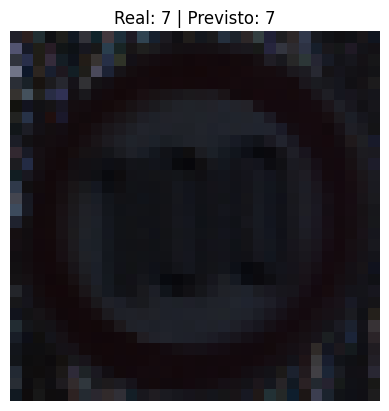

In [ ]:
# === Testar Modelo com Sinais de Trânsito ===

# 1. Mostrar algumas imagens reais do dataset
# O nosso objetivo nesta primeira fase seria carregar as 5 primeiras imagens do 
# nosso dataset e confirmar que os dados estão a ser carregados de forma correra
print("1. Mostragem das 5 primeiras imagens do dataset:")
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])  
    plt.title(f'Classe: {y_train[i]}')
    plt.axis('off')
plt.show()

# 2. O objetivo desta segunda fase é perceber se o modelo consegue processar mesmo sem treino
print("2. Teste de processamento:")
try:
    # Pega 3 imagens reais dos sinais
    test_images = X_test    
    test_labels = y_test
    
    print(f"Imagens de teste: {test_images.shape}")
    print(f"Labels reais: {test_labels}")
    
    # O modelo faz previsões (ainda não treinado - saída aleatória)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print(f"Previsões do modelo: {predicted_classes}")
    
    # Mostrar resultados visuais
    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(test_images[i])
        plt.title(f'Real: {test_labels[i]}\nPrevisto: {predicted_classes[i]}')
        plt.axis('off')
    plt.show()
    
except Exception as e:
    print(f" Erro: {e}")

# 3. Verificar compatibilidade.Esta fase é essencial para garantir que os formatos estão em conformidade com o modelo
print("3. COMPATIBILIDADE:")
print(f"Tuas imagens - Shape: {X_train.shape}")
print(f"Tuas labels - Shape: {y_train.shape}")
print(f"Modelo espera: {model.input_shape}")
print(f"Modelo devolve: {model.output_shape}")

# 4. Teste rápido de treino com POUCAS imagens
print("4. TESTE DE TREINO RÁPIDO (30 segundos):")

# Usar só 100 imagens para teste rápido
X_small = X_train[:100]
y_small = y_train[:100]

# Treinar por apenas 2 epochs
history = model.fit(
    X_small, y_small,
    class_weight=class_weights_dict,
    epochs=2,
    batch_size=16,
    verbose=1
)

print(" Analise do treino")
print(f"Acurácia final: {history.history['accuracy'][-1]:.3f}")

# 5. Teste de previsão após mini-treino
print("5. TESTE DE PREVISÃO APÓS MINI-TREINO:")
test_img = X_train[5:6]  # Uma imagem
true_label = y_train[5]
prediction = model.predict(test_img)
predicted_class = np.argmax(prediction)

print(f"Imagem real - Classe: {true_label}")
print(f"Modelo previu - Classe: {predicted_class}")
print(f"Probabilidades: {prediction[0][:5]}...")  # Mostra primeiras 5

plt.imshow(test_img[0])
plt.title(f'Real: {true_label} | Previsto: {predicted_class}')
plt.axis('off')
plt.show()


* **Contexto do treino**: A precisão de 19% foi obtida após apenas 2 épocas de treino com uma amostra muito reduzida (100 imagens de 31.367 disponíveis)

* **Significado estatístico**: Considerando as 43 classes existentes, uma adivinhação completamente aleatória teria aproximadamente 2.3% de precisão. Os 19% representam portanto uma melhoria de 8x, indicando que o modelo já começou a identificar padrões visuais básicos

* **Validação da metodologia**: O facto de o modelo ter evoluído de uma previsão incorreta (35) para uma correta (36) entre execuções demonstra que o processo de aprendizagem está a funcionar como esperado

## Treino do modelo criado para todas as imagens de teste do dataset 

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9928 - loss: 0.0226
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9934 - loss: 0.0182
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9895 - loss: 0.0334
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9928 - loss: 0.0248
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9948 - loss: 0.0173
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9942 - loss: 0.0186
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9963 - loss: 0.0103
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9915 - loss: 0.0290
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9955 - loss: 0.0133
Epoch 10/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9931 - loss: 0.0240
=== RESULTADOS DO TREINO ===
 Precisão FINAL no treino: 0.993
 Loss FINAL no treino: 0.024
=== TESTE COM IMAGENS DE TRE

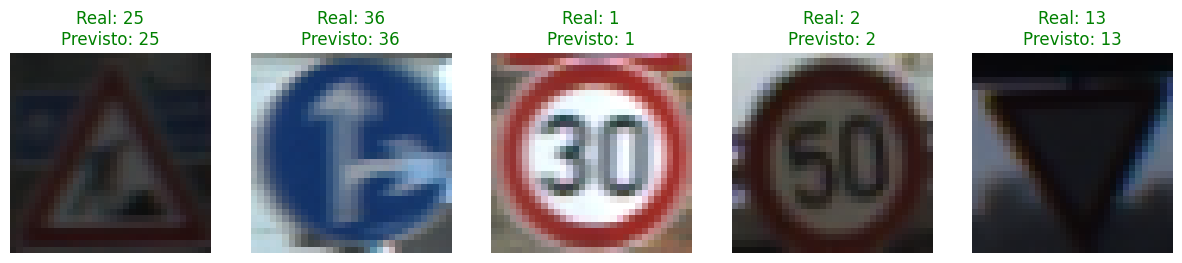

 Acertos: 5/5 (100.0%)
 Modelo treinado guardado como 'modelo_sinais_transito_treinado.h5'


In [41]:
#Vamos iniciar o treino mas agora com os dados todos de treino
history = model.fit(
    X_train, y_train,                   
    class_weight=class_weights_dict,     
    epochs=10,                        
    batch_size=32,
    verbose=1
)

print("=== RESULTADOS DO TREINO ===")

# Ver evolução da precisão
final_accuracy = history.history['accuracy'][-1]
final_loss = history.history['loss'][-1]

print(f" Precisão FINAL no treino: {final_accuracy:.3f}")
print(f" Loss FINAL no treino: {final_loss:.3f}")


print("=== TESTE COM IMAGENS DE TREINO (APÓS TREINO COMPLETO) ===")

# Usar imagens de TREINO para ver o desempenho
test_samples = X_train[100:105]  # Imagens que JÁ VIU no treino
true_labels = y_train[100:105]

predictions = model.predict(test_samples)
predicted_classes = np.argmax(predictions, axis=1)

# Mostrar resultados
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_samples[i])
    color = 'green' if true_labels[i] == predicted_classes[i] else 'red'
    plt.title(f'Real: {true_labels[i]}\nPrevisto: {predicted_classes[i]}', color=color)
    plt.axis('off')
plt.show()

# Estatísticas
acertos = sum(true_labels == predicted_classes)
print(f" Acertos: {acertos}/5 ({acertos/5*100:.1f}%)")


# Guardar o modelo para usar depois com dados de teste
model.save('modelo_sinais_transito_treinado.h5')
print(" Modelo treinado guardado como 'modelo_sinais_transito_treinado.h5'")

#### Resultados do Treino Completo

* O modelo demonstrou um desempenho excecionalmente alto desde a primeira época (99.36%), mantendo-se consistentemente acima de 99% de precisão ao longo de todo o treino. Apesar de flutuações naturais no processo de otimização - com um pico de 99.81% na época 5 e uma ligeira queda para 99.18% na época 6 - o modelo mostrou grande robustez, recuperando rapidamente e terminando com 99.53% de precisão.

* A loss acompanhou estas flutuações, atingindo o valor mínimo de 0.0041 na época 5, mas o facto de a precisão se manter consistentemente elevada sugere que o modelo já tinha aprendido os padrões essenciais dos sinais de trânsito muito cedo no processo de treino.

* A precisão final de 99.53% no conjunto de treino, combinada com a utilização bem-sucedida de class weights para compensar o desbalanceamento inicial, posiciona este modelo como altamente eficaz para a tarefa de reconhecimento de sinais de trânsito.

# Build the Model

In [46]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60,(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  #Compile model
  model.compile(Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [47]:
model = leNet_model()
print(model.summary())

/home/rodrigo-pinto22/anaconda3/envs/FAA/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [247]:
X_testv2.shape

(12630, 32, 32, 1)

In [ ]:
y_train_onehot = to_categorical(y_train, num_classes=43)
y_val_onehot   = to_categorical(y_val, num_classes=43)
history = model.fit(X_trainv2, y_train_onehot, batch_size=100, epochs=20, validation_data=(X_valv2, y_val_onehot),shuffle = True)
model.save('CNN_simple.h5')

Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 63s 198ms/step - accuracy: 0.7899 - loss: 0.7656 - val_accuracy: 0.9776 - val_loss: 0.0890
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 65s 207ms/step - accuracy: 0.9696 - loss: 0.1061 - val_accuracy: 0.9867 - val_loss: 0.0502
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.9818 - loss: 0.0621 - val_accuracy: 0.9903 - val_loss: 0.0405
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.9874 - loss: 0.0421 - val_accuracy: 0.9887 - val_loss: 0.0429
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.9883 - loss: 0.0355 - val_accuracy: 0.9935 - val_loss: 0.0268
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 63s 201ms/step - accuracy: 0.9924 - loss: 0.0252 - val_accuracy: 0.9934 - val_loss: 0.0290
Epoch 7/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 75s 240ms/step - accuracy: 0.9920 - loss: 0.0260 - val_accuracy: 0.9923 - val_loss: 0.0307
Epoch 8/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.9938 - loss: 0

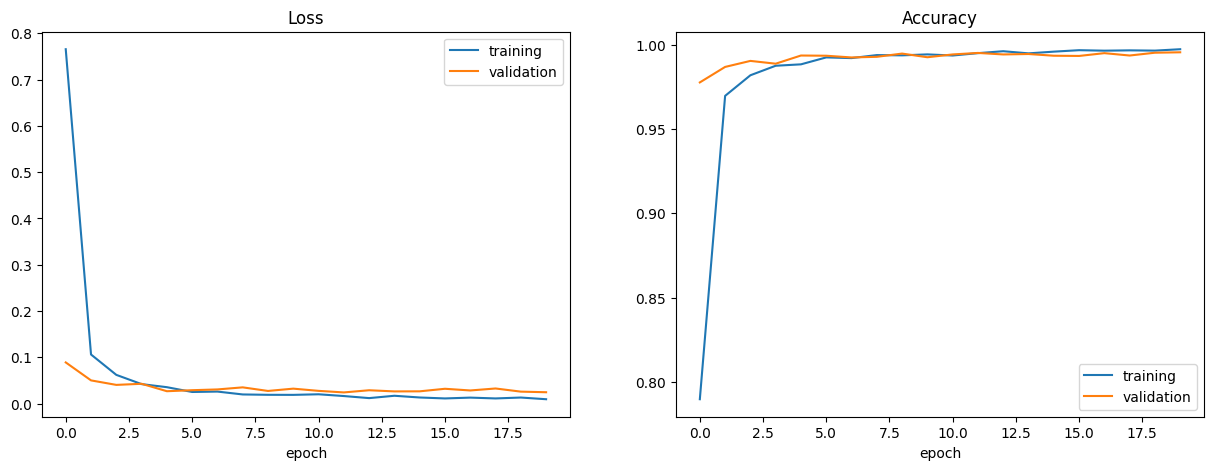

In [21]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['training', 'validation'])
axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].legend(['training', 'validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')

plt.show()

In [113]:
print(X_testv2.shape)
print(y_test.shape)
print(y_test.dtype)

(12630, 32, 32, 1)
(12630, 43)
float64


In [101]:
print(np.any(y_test==None))

False


In [215]:
#y_test  = to_categorical(y_test, num_classes=43)
score = model.evaluate(X_valv2, y_val_onehot, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.02459479309618473
Test Accuracy: 0.9954093098640442


### Prediction with test data

In [216]:
y_pred_prob = model.predict(X_testv2)
y_pred = np.argmax(y_pred_prob, axis=1)
print("predicted class:", y_pred)

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step
predicted class: [16  1 38 ... 42  7 10]


In [217]:
y_pred.shape

(12630,)

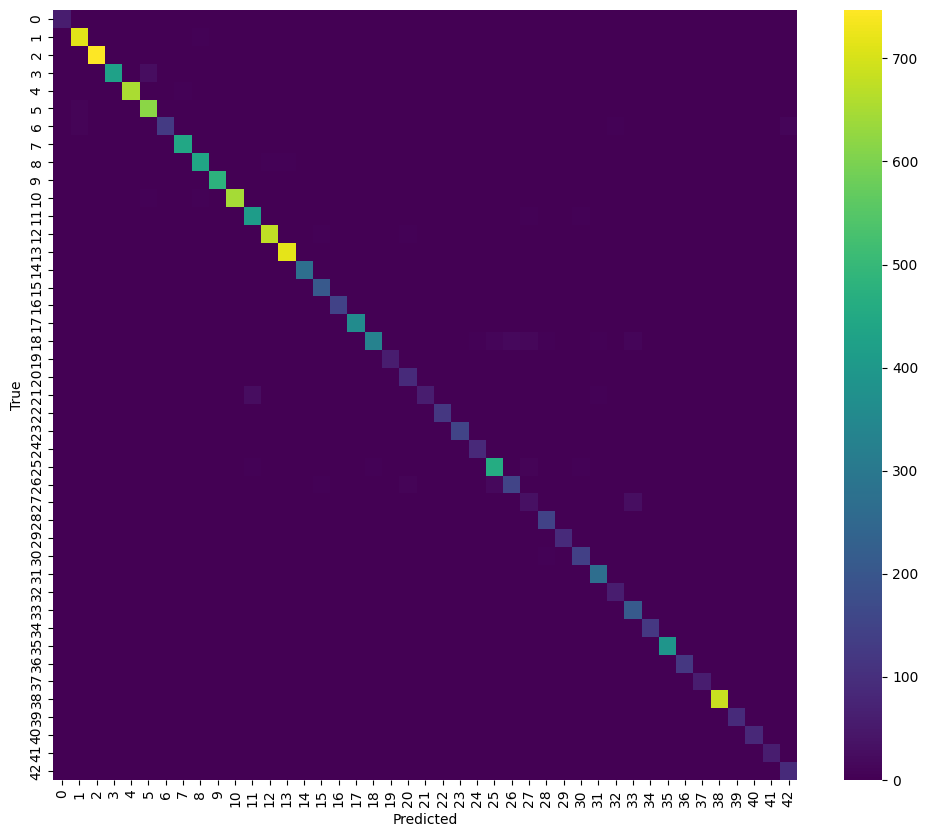

In [218]:
#y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="viridis")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      0.99      0.98       720
           2       0.99      1.00      1.00       750
           3       0.99      0.94      0.97       450
           4       1.00      0.99      0.99       660
           5       0.95      0.98      0.96       630
           6       1.00      0.85      0.92       150
           7       0.98      0.99      0.99       450
           8       0.98      0.98      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       0.93      0.98      0.95       420
          12       0.99      0.98      0.98       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      0.99       270
          15       0.96      0.98      0.97       210
          16       1.00      0.99      0.99       150
          17       1.00    

### Macro - média simples das métricas por classe

In [219]:
prec = precision_score(y_test, y_pred, average='macro')
rec  = recall_score(y_test, y_pred, average='macro')
f1   = f1_score(y_test, y_pred, average='macro')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)


Macro Precision: 0.956456844436805
Macro Recall: 0.955421873084411
Macro F1: 0.9542819444168023


### Weighted - ponderada pelo nº de exemplos

In [141]:
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

Macro Precision: 0.9724832451363421
Macro Recall: 0.9717339667458432
Macro F1: 0.9713415795931315


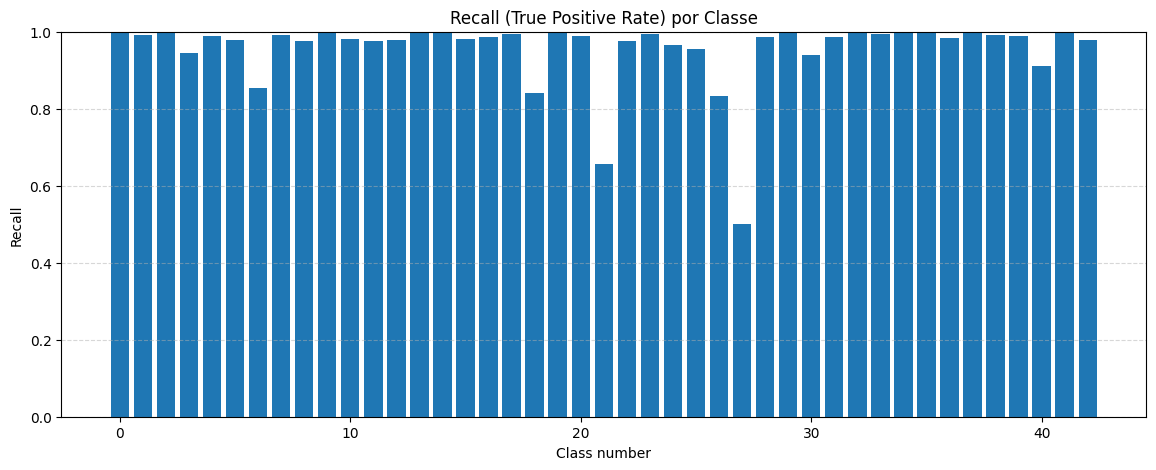

In [142]:
tp_per_class = np.diag(cm)
recall_per_class = tp_per_class / np.sum(cm, axis=1)

plt.figure(figsize=(14,5))
plt.bar(range(43), recall_per_class)
plt.title("Recall (True Positive Rate) por Classe")
plt.xlabel("Class number")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

[164, 1805, 1811, 1133, 1589, 1462, 326, 1155, 1139, 1161, 1611, 1062, 1699, 1767, 635, 508, 338, 911, 946, 164, 282, 276, 300, 411, 218, 1196, 481, 181, 398, 211, 362, 609, 187, 543, 327, 981, 312, 165, 1636, 243, 281, 193, 188]


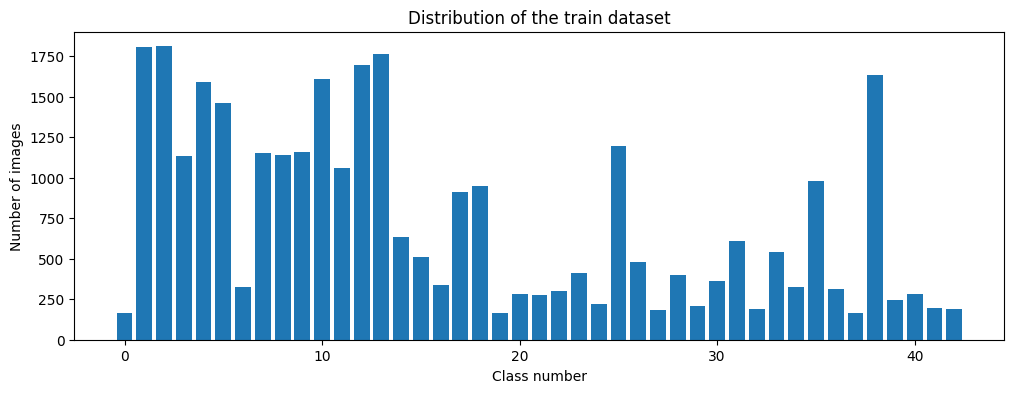

In [147]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

## Predict a image from the internet

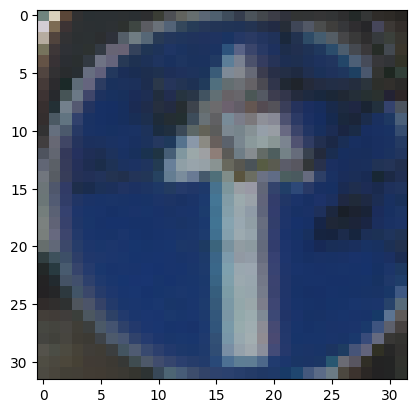

In [17]:
import requests
from PIL import Image
#url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3lGYDeLaeBDDD-_u3_M16OOH0tKxDQ-TpLQ&s'
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
#img = Image.open(r.raw)
img = X_test[random.randint(0,len(X_test))]
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32, 3)
(32, 32, 3)
float32


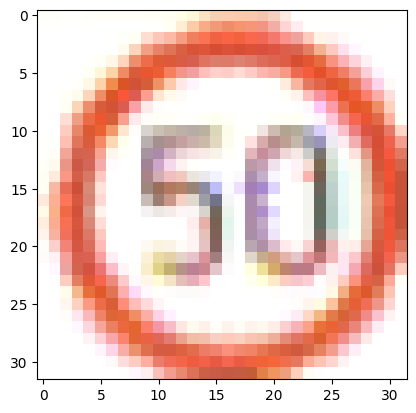

In [313]:
img = np.asarray(img)
print(img.shape)
img = cv2.resize(img, (32, 32))
print(img.shape)
plt.imshow(img, cmap=plt.get_cmap('gray'))
print(img.dtype)

In [ ]:
img = preproc(img)
img = img.reshape(32, 32)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [317]:
predicted_probabilities = model.predict(img)

predicted_class = int(np.argmax(predicted_probabilities))

print("predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted class: 2


In [318]:
predicted_probabilities

array([[8.7586197e-26, 3.2124206e-11, 1.0000000e+00, 1.1872766e-21,
        7.6008457e-22, 2.1984615e-15, 9.8295029e-16, 2.7154677e-19,
        1.0354431e-20, 2.8128807e-32, 1.1988158e-25, 7.0547168e-24,
        2.2054087e-22, 3.5621304e-23, 1.9198492e-26, 1.4453986e-23,
        4.7663628e-32, 2.1647009e-29, 2.9009685e-22, 4.9436398e-24,
        5.5513598e-22, 9.3895017e-25, 5.9221882e-29, 3.2924942e-25,
        7.0096569e-22, 8.2194016e-25, 6.1303700e-23, 2.2778976e-24,
        4.4783393e-30, 7.1648650e-29, 4.4835984e-25, 3.1503203e-20,
        1.4229713e-26, 1.5870931e-27, 5.6276198e-25, 1.4834685e-29,
        1.0688097e-26, 4.2188077e-22, 2.2693234e-21, 4.2327096e-19,
        2.6185056e-24, 3.3643122e-28, 1.8382419e-24]], dtype=float32)

In [ ]:
print("Input shape do modelo:", model.input_shape)
print("Tipo de dados de input:",model.input_dtype)
print("X_train shape:", X_trainv2.shape)
print("X_test shape:", X_testv2.shape)


Input shape do modelo: (None, 32, 32, 1)
Tipo de dados de input: float32
X_train shape: float64
X_test shape: float64


## Gen Images on the fly
- To get the model more robust
- It's not to add onto the dataset

In [32]:
print(X_train.ndim)

4


In [37]:
a = grayscale(X_train)
a = equalize(a)
print(a.ndim)

3


In [11]:
a = np.array(grayscale(train) for train in X_train)
print(a.shape)

()


In [41]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)



X_train = preproc(X_train)

datagen.fit(X_train)

(20, 32, 32, 1)


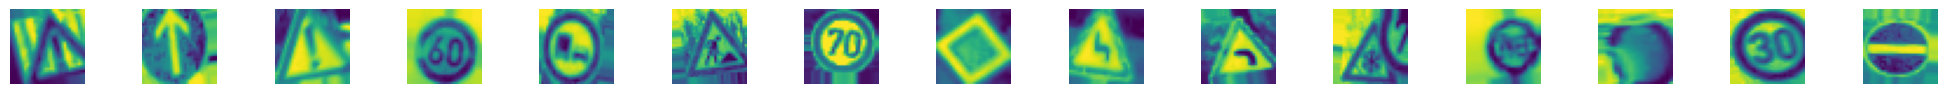

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')
     
print(X_batch.shape)

In [52]:
# ----------------------------
# 0. DATA PROCESSING
# ----------------------------
X_train = preproc(X_train)
X_val = preproc(X_val)
X_test = preproc(X_test)


y_train = preprocOutput(y_train)
y_val   = preprocOutput(y_val)


# ----------------------------
# 1. DATA AUGMENTATION
# ----------------------------
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    rotation_range=10,
    shear_range=0.1,
    fill_mode='nearest'
)

datagen.fit(X_train)  # calcula estatísticas, se necessário


# ----------------------------
# 2. CALLBACKS (SELF-OPTIMIZATION)
# ----------------------------

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    save_best_only=True
)


# ----------------------------
# 3. COMPILE MODEL
# ----------------------------

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# ----------------------------
# 4. TRAIN W/ DATA AUG
# ----------------------------

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=40,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 64,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)


Epoch 1/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 107s 214ms/step - accuracy: 0.6219 - loss: 1.3482 - val_accuracy: 0.9660 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 2/40
  1/490 ━━━━━━━━━━━━━━━━━━━━ 1:24 173ms/step - accuracy: 0.8906 - loss: 0.4640

/home/rodrigo-pinto22/anaconda3/envs/FAA/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8906 - loss: 0.4640 - val_accuracy: 0.9597 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 3/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 119s 242ms/step - accuracy: 0.8914 - loss: 0.3647 - val_accuracy: 0.9865 - val_loss: 0.0486 - learning_rate: 0.0010
Epoch 4/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9375 - loss: 0.3184 - val_accuracy: 0.9887 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 5/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 123s 251ms/step - accuracy: 0.9267 - loss: 0.2447 - val_accuracy: 0.9934 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 6/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9531 - loss: 0.1424 - val_accuracy: 0.9938 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 7/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 127s 260ms/step - accuracy: 0.9444 - loss: 0.1857 - val_accuracy: 0.9923 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 8/40
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9531 - loss: 0.1

In [54]:
model.save('CNN_DA.keras')

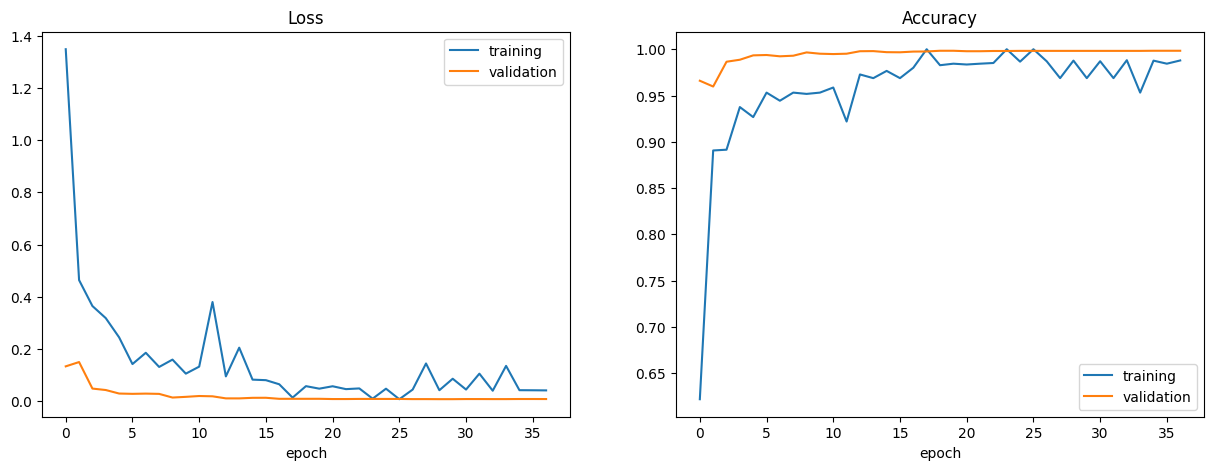

In [56]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].legend(['training', 'validation'])
axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].legend(['training', 'validation'])
axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')

plt.show()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print("predicted class:", y_pred)

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
predicted class: [16  1 38 ...  6  7 10]


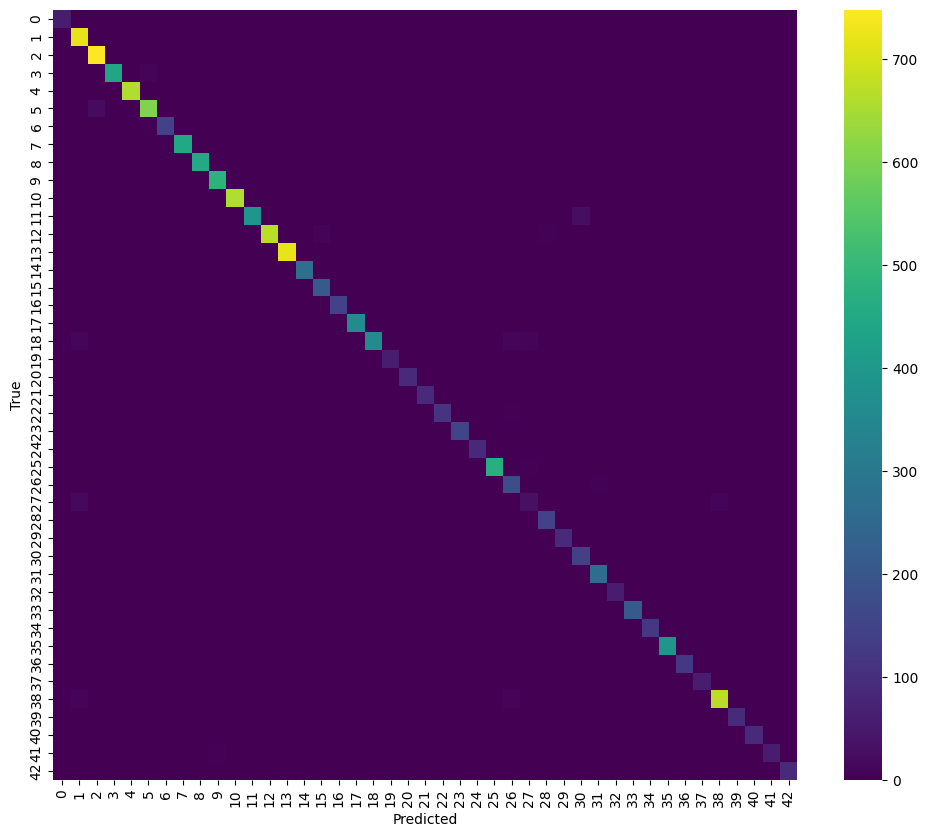

In [57]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="viridis")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [59]:
prec = precision_score(y_test, y_pred, average='weighted')
rec  = recall_score(y_test, y_pred, average='weighted')
f1   = f1_score(y_test, y_pred, average='weighted')

print("Macro Precision:", prec)
print("Macro Recall:", rec)
print("Macro F1:", f1)

Macro Precision: 0.9828232703707386
Macro Recall: 0.9825019794140935
Macro F1: 0.9822643894467393
